In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import GCNN
from dataset import HD5Dataset

In [50]:
# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=1337, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

Created memory map arrays.


In [93]:
# Load the trained GCNN model
model = GCNN(data.get_number_features(),
            units_graph_convolutions = [64, 64, 64, 64, 64, 64, 64, 64],
            units_fully_connected = [32, 16, 1],
            use_batchnorm = False,
            dropout_rate = 0.0)
model.load_weights('training/baseline_gcnn/cp-0003.ckpt')

In [94]:
test_idx = data._get_idx('train')

In [ ]:
# Evaluate the model on all the data
batch_size = 128
y_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='train'),
                       steps=int(np.ceil(data.size(dataset='train') / batch_size)))

In [ ]:
y_model = (y_model >= 0.5).astype(np.int)

In [ ]:
y_model = y_model.squeeze()

In [ ]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [ ]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [ ]:
total_charge_sorted = np.sort(total_charge)

In [ ]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [ ]:
y_model.shape, y_gnd.shape

In [ ]:
y_model, y_gnd

In [ ]:
accuracies = []
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    accuracy_baseline = (y_gnd[mask] == y_baseline[mask]).sum() / mask.sum()
    accuracy_model = (y_model[mask] == y_gnd[mask]).sum() / mask.sum()
    accuracies.append([accuracy_baseline, accuracy_model])
accuracies = np.array(accuracies)

In [ ]:
accuracies

Text(0, 0.5, 'Accuracy')

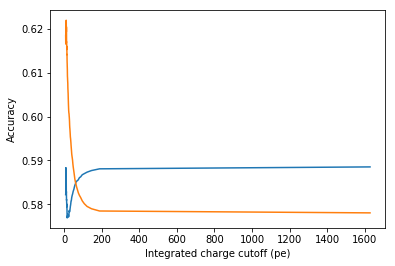

In [127]:
plt.plot(cutoffs, accuracies[:, 0])
plt.plot(cutoffs, accuracies[:, 1])

plt.xlabel('Integrated charge cutoff (pe)')
plt.ylabel('Accuracy')

In [131]:
np.unique(y_model)

array([0])